Training size: (28938, 169)
Testing size: (17626, 169)
scale_pos_weight = 7.506172839506172
Training model...
Predicting...

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16483
           1       0.91      0.74      0.81      1143

    accuracy                           0.98     17626
   macro avg       0.95      0.87      0.90     17626
weighted avg       0.98      0.98      0.98     17626

Precision: 0.9111592632719393
F1 Score: 0.814133591481123


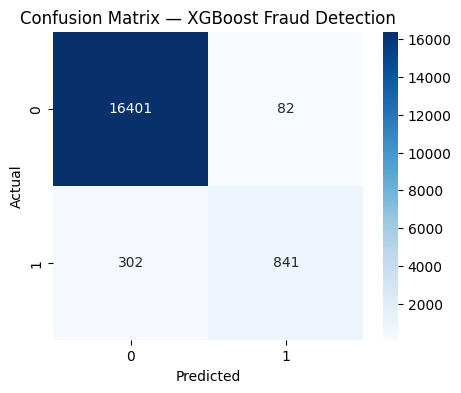

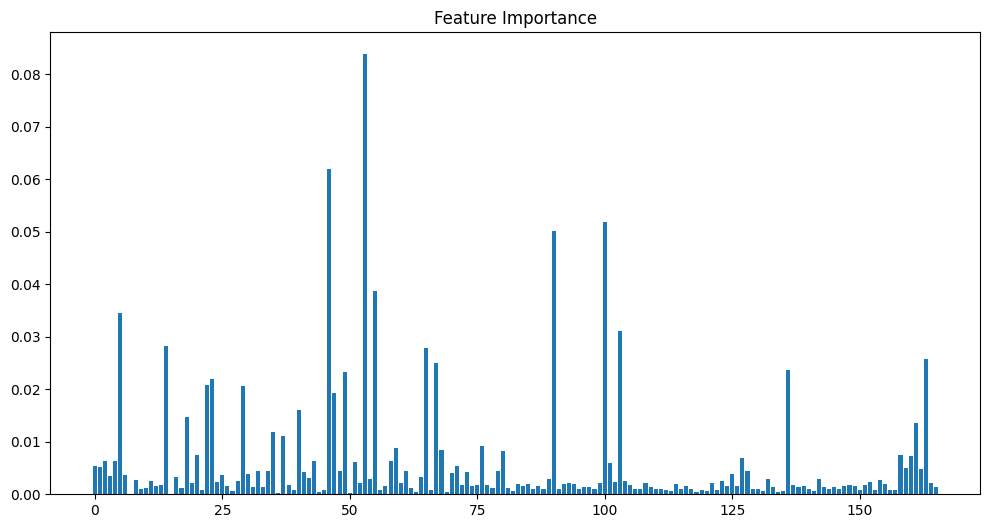

C:\temp\ipykernel_15532\275305474.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['fraud_prob'] = y_prob



Model saved to models/xgboost_model.pkl
Predictions saved to data/processed/xgb_predictions.csv


In [5]:
# ===============================
# PHASE 2 — SUPERVISED MODEL (XGBoost)
# Time-based Train-Test Split
# ===============================

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import joblib
import seaborn as sns

# Load processed data
data = pd.read_csv("../data/processed/labeled_data.csv")

# Feature f1 is the time-step feature
data['f1'] = data['f1'].astype(int)

# Train-test split by time
train = data[data['f1'] <= 32]   # Early steps → train
test  = data[data['f1'] > 32]    # Future steps → test

print("Training size:", train.shape)
print("Testing size:", test.shape)

X_train = train.drop(['txId', 'class', 'binary_label'], axis=1)
y_train = train['binary_label']

X_test = test.drop(['txId', 'class', 'binary_label'], axis=1)
y_test = test['binary_label']

# Class imbalance fix: scale_pos_weight = (normal_count / fraud_count)
neg, pos = np.bincount(y_train)
scale = neg / pos
print("scale_pos_weight =", scale)

model = XGBClassifier(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale
)

print("Training model...")
model.fit(X_train, y_train)

print("Predicting...")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]  # Fraud probability

# Evaluation
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost Fraud Detection")
plt.show()

# Feature Importance Plot
importance = model.feature_importances_
plt.figure(figsize=(12,6))
plt.bar(range(len(importance)), importance)
plt.title("Feature Importance")
plt.show()

# Save predictions for fusion
import os
os.makedirs("data/processed", exist_ok=True)
test['fraud_prob'] = y_prob
test.to_csv("../data/processed/xgb_predictions.csv", index=False)

# Save model
os.makedirs("models", exist_ok=True)
joblib.dump(model, "../models/xgboost_model.pkl")
print("\nModel saved to models/xgboost_model.pkl")
print("Predictions saved to data/processed/xgb_predictions.csv")


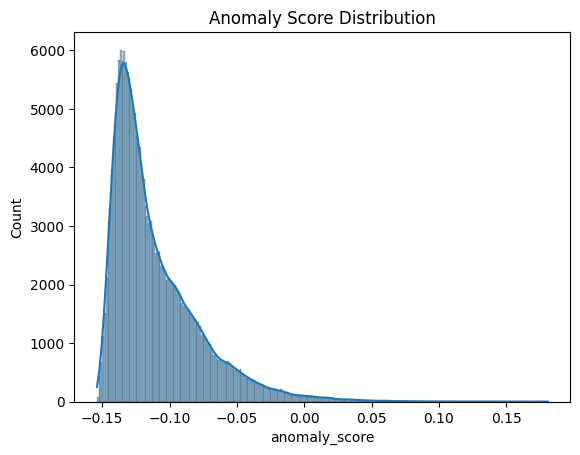

In [6]:
full_data = pd.read_csv("../data/processed/if_predictions.csv")
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(full_data["anomaly_score"], kde=True)
plt.title("Anomaly Score Distribution")
plt.show()
